In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Paso 1. Detectar cada círculo

[[[ 702  424   81]
  [ 944  332   81]
  [ 436 1064   80]
  [ 768  260   81]
  [ 876  492   82]
  [ 424  122   80]
  [ 502  906   80]
  [ 606 1140   81]
  [ 676  976   82]
  [ 230  612   80]
  [ 566  752   82]
  [ 632  590   81]
  [ 300  438   81]
  [ 810  652   82]
  [ 168  760   81]
  [ 100  918   81]
  [ 364  280   81]
  [ 736  828   85]
  [ 600  192   80]
  [ 528  354   82]
  [ 264  992   82]
  [ 470  508   81]
  [ 334  838   81]
  [ 402  670   81]]]


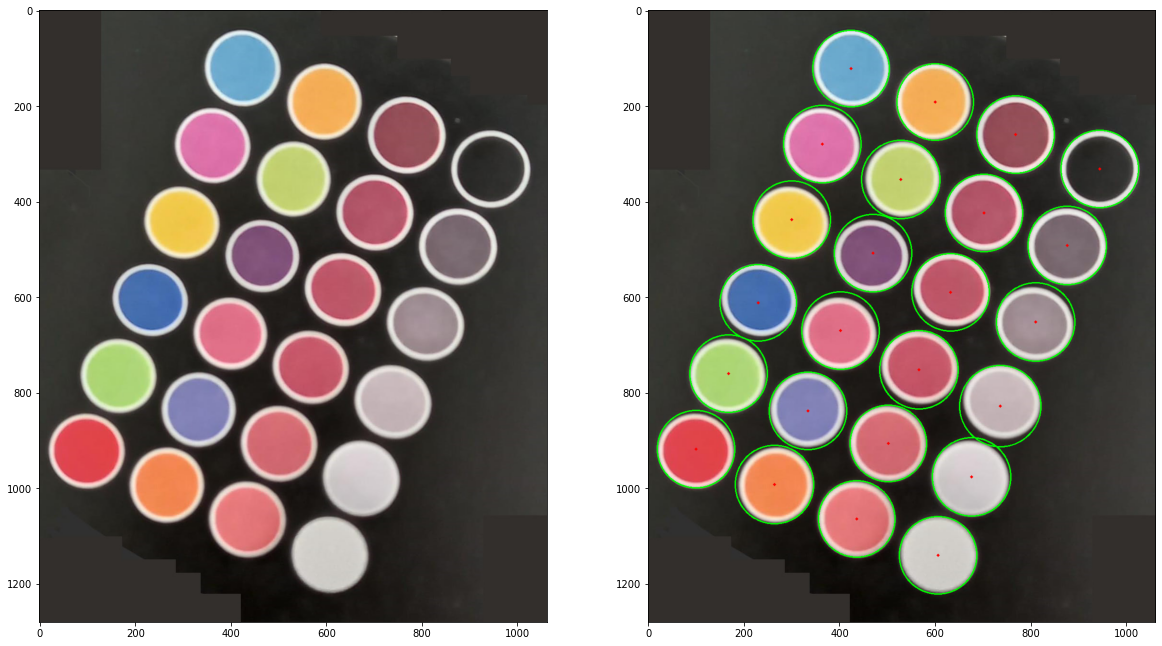

In [2]:
def detectCircles(img):
    copy = img.copy()
    # Convert to grayscale.
    gray = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
    
    # Blur using 3 * 3 kernel.
    gray_blurred = cv2.blur(gray, (3, 3))

    # Apply Hough transform on the blurred image.
    detected_circles = cv2.HoughCircles(gray_blurred, 
                       cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
                   param2 = 30, minRadius = 80, maxRadius = 90)
    
    if detected_circles is not None:
        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(detected_circles))
        
        for pt in detected_circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]
            
            # Draw the circumference of the circle.
            cv2.circle(copy, (a, b), r, (0, 255, 0), 2)

            # Draw a small circle (of radius 1) to show the center.
            cv2.circle(copy, (a, b), 1, (255, 0, 0), 3)
    
    return detected_circles,copy


img = cv2.imread('circulos_colores.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

circles,newImg = detectCircles(img)
print(circles)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(newImg)
plt.show()

# Paso 2. Identificar los círculos de las 4 esquinas: negro, blanco, azul y rojo.

In [3]:
def identifyCircles(circles,img,slicesize=9):
    circles2 = circles[0]

    downleft_corner_idx = np.argmin(circles2[:,0],axis=0)
    downleft_corner = deepcopy(circles2[downleft_corner_idx])
    
    upright_corner_idx = np.argmax(circles2[:,0],axis=0)
    upright_corner = deepcopy(circles2[upright_corner_idx])
    
    upleft_corner_idx = np.argmin(circles2[:,1],axis=0)
    upleft_corner = deepcopy(circles2[upleft_corner_idx])
    
    downright_corner_idx = np.argmax(circles2[:,1],axis=0)
    downright_corner = deepcopy(circles2[downright_corner_idx])
    
    interest_circles = (upleft_corner,upright_corner,downleft_corner,downright_corner)
    interest_circles = np.uint16(np.around(interest_circles))

    img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

    circles_rgb = np.zeros_like(interest_circles)

    for idx,circle in enumerate(interest_circles):
        x,y,radius = circle
        # print("Center:",(x,y))

        R = np.median(img[y-slicesize:y+slicesize,x-slicesize:x+slicesize,0])
        G = np.median(img[y-slicesize:y+slicesize,x-slicesize:x+slicesize,1])
        B = np.median(img[y-slicesize:y+slicesize,x-slicesize:x+slicesize,2])
        # print("RGB of median:",(R,G,B))
        circles_rgb[idx] = np.array((R,G,B))

        H = np.median(img_hsv[y-slicesize:y+slicesize,x-slicesize:x+slicesize,0])
        # print("Hue of median:",H)

        if 90 < H < 130:
            blue_idx = idx
        elif H < 10 or H > 170:
            red_idx = idx

    black_idx = np.argmin(np.sum(circles_rgb,axis=1))
    white_idx = np.argmax(np.sum(circles_rgb,axis=1))

    resp = {'white':interest_circles[white_idx],'black':interest_circles[black_idx],'blue':interest_circles[blue_idx],'red':interest_circles[red_idx]}
    # Should return the cirlces
    return resp


interest_circles = identifyCircles(circles,img)
print(interest_circles)



{'white': array([ 606, 1140,   81], dtype=uint16), 'black': array([944, 332,  81], dtype=uint16), 'blue': array([424, 122,  80], dtype=uint16), 'red': array([100, 918,  81], dtype=uint16)}


# Paso 3. Ajustar la perspectiva de la imagen

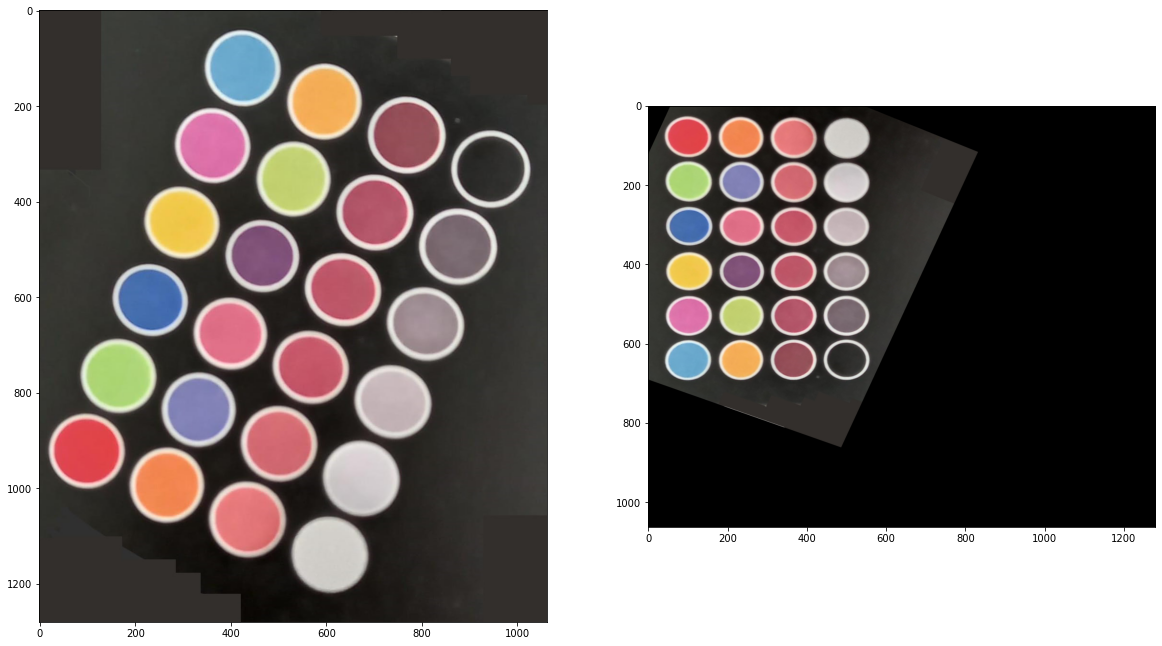

In [4]:
def fixPerspective(img,pts1,pts2,dim):
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)

    frame = img.copy()
    # Wrap the transformed image
    result = cv2.warpPerspective(frame, matrix, dim)

    return result


dim = img.shape[0:2]
pts1 = interest_circles['blue'][0:2],interest_circles['black'][0:2],interest_circles['red'][0:2],interest_circles['white'][0:2]
pts1 = np.float32(pts1)
pts2 = np.float32([[100,640],[500,640],[100,80],[500,80]])

result = fixPerspective(img,pts1,pts2,dim)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(result)
plt.show()